# Analyzing Single Neuron Activity

In this tutorial we will examine single-neuron data collected from human patients.

This tutorial was originally developed by 
[Salman Qasim](https://seqasim.wixsite.com/research),
and has been updated by
[Tom Donoghue](https://tomdonoghue.github.io/). 

### Requirements

As well as standard scientific Python packages, this tutorial requires 
[pynwb](https://github.com/NeurodataWithoutBorders/pynwb).

In [204]:
# Imports - standard scientific Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.signal import fftconvolve
from scipy.stats import ttest_rel

# Imports - single-unit related 
from pynwb import NWBHDF5IO

In [84]:
# Import seaborn for plot aesthetics
import seaborn as sns
sns.set_context('talk')

## Overview

The predominant way in which a neuron communicates is through **action potentials**. These are rapid depolarizations across the neuronal cell membrane that culminate in a neuron releasing neurotransmitters that can do all sorts of things, like excite or inhibit action potentials in other neurons. Because action potentials are characterized by a large and fast change in membrane potential they can be recorded by microwires placed near the neuronal membrane, making them the most direct "biomarker" of neural activity. 

When we look at neuronal spiking during a behavioral task, we are often looking for increases in the rate of spiking related to behavioral variables. This is thought to imply a relationship between the stimulus and the neuron's spiking, and is called **rate coding**. Here, we are going to cover some of the basics of analyzing single neuron responses. 

## First Dataset: Object Presentation

The first dataset we will use is a an openly available dataset from human patients performing a recognition memory, provided by the 
[Rutishauser Lab](https://www.cedars-sinai.edu/research/labs/rutishauser.html). 

In this task, subjects are presented with pictures of objects, that they are later asked to recall. For our purposes, we will focus on the object presentation. 

For convenience, an example subject is included in this repository. The full dataset is available on 
[OSF repository](https://osf.io/cd6qp/), and described in this 
[paper](https://doi.org/10.1038/s41597-020-0415-9).

### Load NWB File

The data that we are loading are in the [NWB](https://www.nwb.org/) format.

In this tutorial, we won't go into much details on NWB files. For more information on these files, see these
[NWB examples](https://github.com/TomDonoghue/NWBExamples).

In [154]:
# Load datafile
file_name = 'object_data.nwb'
io = NWBHDF5IO('data/' + file_name, 'r')
nwbfile = io.read()

### Check Units

In [155]:
# Check how many units in the current file
n_units = len(nwbfile.units)
print(n_units)

38


In [156]:
# Set index for the unit of interest
s_ind = 0

In [157]:
# Extract the waveform for the unit of interest
waveform = nwbfile.units['waveform_mean_encoding'][s_ind, :]

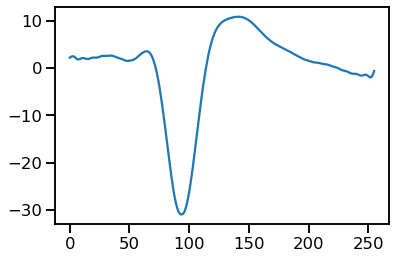

In [158]:
# Plot the waveform of the unit of interest
plt.plot(waveform)

In [159]:
# Get spikes from a neuron of interest
spikes = nwbfile.units.get_unit_spike_times(s_ind)

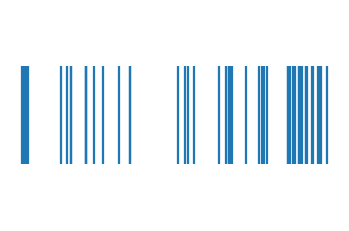

In [160]:
# Plot a raster of a series of spikes
plt.eventplot(spikes[0:50])
plt.axis('off');

### Event Information

In [161]:
# Check the encoding of event information in the NWB file
nwbfile.intervals['trials']

trials pynwb.epoch.TimeIntervals at 0x47812648043856
Fields:
  colnames: ['start_time' 'stop_time' 'stim_on_time' 'stim_off_time' 'delay1_time'
 'delay2_time' 'stim_phase' 'stimCategory' 'category_name'
 'external_image_file' 'new_old_labels_recog' 'response_value'
 'response_time']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    stim_on_time <class 'hdmf.common.table.VectorData'>,
    stim_off_time <class 'hdmf.common.table.VectorData'>,
    delay1_time <class 'hdmf.common.table.VectorData'>,
    delay2_time <class 'hdmf.common.table.VectorData'>,
    stim_phase <class 'hdmf.common.table.VectorData'>,
    stimCategory <class 'hdmf.common.table.VectorData'>,
    category_name <class 'hdmf.common.table.VectorData'>,
    external_image_file <class 'hdmf.common.table.VectorData'>,
    new_old_labels_recog <class 'hdmf.common.table.VectorData'>,
    response_value <class 'hdmf.common.table.VectorData'>,
    respo

In [162]:
# Check the behavioural information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()

,start_time,stop_time,stim_on_time,stim_off_time,delay1_time,delay2_time,stim_phase,stimCategory,category_name,external_image_file,new_old_labels_recog,response_value,response_time
id,,,,,,,,,,,,,
0,5850.331408,5854.419808,5850.331408,5851.335488,5851.836208,5854.419808,learn,5,smallAnimal,newolddelay\smallAnimal\7.jpg,NA,0.0,5853.420608
1,5854.557488,5858.135168,5854.557488,5855.551568,5856.052208,5858.135168,learn,4,phones,newolddelay\phones\34.jpg,NA,1.0,5857.137208
2,5858.237848,5864.684688,5858.237848,5859.236888,5859.737608,5864.684688,learn,2,landscapes,newolddelay\landscapes\31.jpg,NA,1.0,5863.686528
3,5864.813608,5869.041048,5864.813608,5865.816488,5866.317208,5869.041048,learn,3,mobility,newolddelay\mobility\30.jpg,NA,1.0,5868.038848
4,5869.181048,5872.305808,5869.181048,5870.182848,5870.683568,5872.305808,learn,3,mobility,newolddelay\mobility\13.jpg,NA,1.0,5871.304608


In [163]:
# Check the available image conditions
set(nwbfile.intervals['trials'].category_name.data[:])

{'houses', 'landscapes', 'mobility', 'phones', 'smallAnimal'}

In [164]:
# Get the stimulus presentation times
stim_ons = nwbfile.intervals['trials']['stim_on_time'][:]
stim_offs = nwbfile.intervals['trials']['stim_off_time'][:]

In [165]:
# Get the stimulus onset times for a stimulus category of interest
cond = 'phones'
cond_stim_times = behav[behav.category_name == cond].stim_on_time.values

### Task Related Activity

In [207]:
def get_trial_spikes(spikes, trial_times, window=1):
    """Compute the average difference in spike firing pre vs post time point of interest."""
    
    trial_spikes = []
    for trial_time in trial_times:
        temp = get_spike_time_range(spikes, trial_time - window, trial_time + window)
        trial_spikes.append(temp - trial_time)
        
    return trial_spikes

In [208]:
# Extract spikes for a unit of interest
s_ind = 0
spikes = nwbfile.units.get_unit_spike_times(s_ind)

In [213]:
# Collect spikes by trial
trial_spikes = get_trial_spikes(spikes, cond_stim_times)

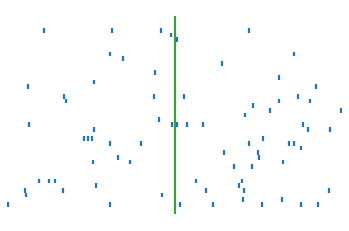

In [214]:
# Plot the event-related raster plots
plt.eventplot(trial_spikes);
plt.vlines(0, -1, len(trial_spikes) + 1, color='green', alpha=0.75);
plt.xlim([-1, 1])
plt.axis('off');

#### Statistical Tests

In the above, we have organized our data in order to visualize if there appear to be object related changes in neuron activity. 

Here, we will take a very simple (non-ideal) test to get a sense of if there is a significant change in firing: a paired t-test on pre & post firing. 

In [216]:
# Reconstruct number of pre & post stim neurons
n_pre, n_post = [], []
for trial in trial_spikes:
    n_pre.append(sum(trial < 0))
    n_post.append(sum(trial > 0))

In [212]:
# Check for a significant change in firing
ttest_rel(n_pre, n_post)

Ttest_relResult(statistic=-1.3254270092150517, pvalue=0.1927419495036985)

### Object Dataset: Possible Extensions

So far we explored a simple way to examine if there might be object related activity in the dataset, with simple visualizations and statistical approaches. 

## Second Dataset: Spatial Navigation

We will primarily be analyzing data from the Train task (which Josh covered in his talk).
For reference for this task, see the [associated paper](https://www.nature.com/articles/s41593-019-0523-z).

In this section we will go over some simple single neuron analyses with respect to spatial position and memory. 

In [11]:
# Load data file
file_name = 'spatial_data.nwb'
io = NWBHDF5IO('data/' + file_name, 'r')
nwbfile = io.read()

In [12]:
# Check how many units in the current file
n_units = len(nwbfile.units)
print(n_units)

23


In [13]:
# Set index to access a unit of interest
s_ind = 0

In [103]:
# Extract spikes for the unit of interest
spikes = nwbfile.units.get_unit_spike_times(s_ind)

### Helper Functions

In [85]:
def compute_spike_rate(spikes):
    """Estimate spike rate from a vector of spike times, in seconds."""
    
    return len(spikes) / (spikes[-1] - spikes[0])

def get_spike_time_range(spikes, tmin, tmax):
    """Extract spike times for a particular time range."""
    
    return spikes[np.squeeze(np.logical_and([spikes > tmin], [spikes < tmax]))]

### Descriptive Explorations

#### Firing Rate

In [86]:
# Compute the firing rate of the neuron
fr = compute_spike_rate(spikes) * 1000

In [90]:
# Check the firing rate of the unit of interest
print('The firing rate is: {:2.2f}'.format(fr))

The firing rate is: 11.93


In [91]:
# Compute the firing rate for all neurons
frs = [compute_spike_rate(nwbfile.units.get_unit_spike_times(ind)) * 1000 \
    for ind in range(n_units)]

<BarContainer object of 23 artists>

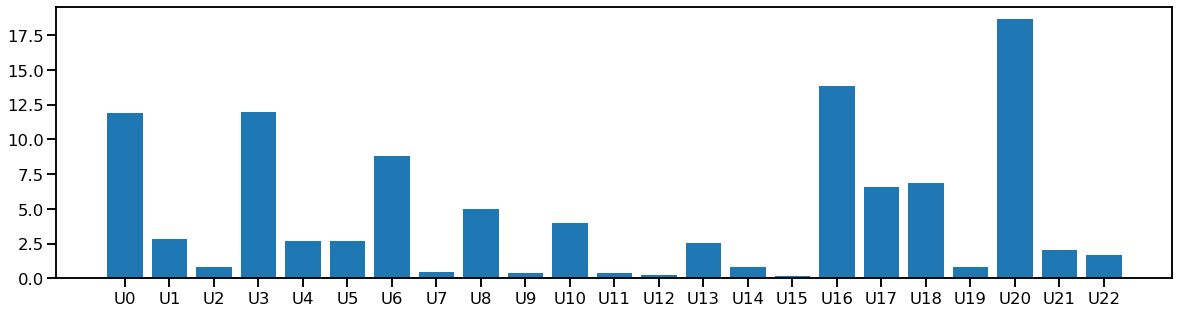

In [93]:
# Plot the firing rate for all neurons
labels = ['U' + str(ind) for ind in range(len(frs))]
_, ax = plt.subplots(figsize=(20, 5))
ax.bar(labels, frs)

This tells you how active, in general, each neuron was during the recording session. 

#### Inter-Spike Interval

One way to assess spiking activity is to look at the time interval between each spike (aka the **interspike interval**). 

In [94]:
# Compute ISI for a single neuron
isi = np.diff(np.array(spikes))

Text(0, 0.5, 'density')

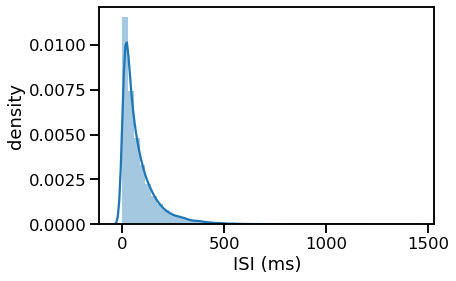

In [95]:
# Plot the inter-spike intervals
sns.distplot(isi)
plt.xlabel('ISI (ms)')
plt.ylabel('density')

#### Coefficient of Variation


The CV does not capture potential variability on longer time scales especially if there's drift in the neuron's mean firing rate over time. A measure of spike time variability taking this long-term variability into account is the Fano factor, the ratio of the mean spike count and the variance the spike count within a time window. We will compute that a little later.

Another useful thing that ISI distribution can tell you is if the neuron you are looking at is a **bursty** neuron. By that, I mean a neuron that tends to fire a lot of action potentials in short bursts, rather than as isolated single spikes. As you can imagine, bursty neurons tend to violate Poisson assumptions and have ISI distributions that look a little more bimodal, with lots of spikes close together, and lots of bursts far apart. But that is a good segue into......

In [21]:
# Compute coefficient of variation
cv = np.std(isi) / np.mean(isi)

In [22]:
# Check the computed CV
print(cv)

1.1425758665939532


### Data Representations

Now let's explore some different ways to represent the data.

#### Spike Times

....

#### Spike Trains

...

#### Continuous Firing Rates

Before we go any further, let's look at some spike trains. We didn't do this before because we didn't know when the task started and stopped - now we do, and can define a spike train using the spikes that happened during the task.

In [23]:
#nwbfile.intervals

In [24]:
# Settings
bin_width_st = 1   # this means our time resolution is 1 ms - sufficient for spike train generation and analysis 
st_sr = 1000       # This is our sampling rate 

In [25]:
# 
times = nwbfile.acquisition['position']['position'].timestamps[:]
start, end = times[0], times[-1]

In [26]:
# # Let's make a spike train of spikes during the task
st = spikes

# # # find the indices corresponding to spikes during the task
#a1, a2 = (116922.44817708334, 2284469.5921875)
st_to_keep = np.where(np.logical_and(st>=start, st<=end))[0].astype(int)

# # # we can baseline the spikes to the start of the task for generating a spike train 
st_baselined = st[st_to_keep] - start

ms_ix = np.arange(start, end + np.diff(times)[0], bin_width_st) - start

# # # spike times are in ms, but are sampled at 30 KHz meaning  we have to round them to ms resolution
rounded_spike_times = np.round(st_baselined).astype(int)

# # # generate a spike train - a binary vector of 0's and 1's that is indexed by the spike times. Remember the bin width is 1 ms 
spiketrain = np.zeros(len(ms_ix))

# # # note we have to subtract 1 for pythonic indexing
spiketrain[rounded_spike_times - 1] = 1 

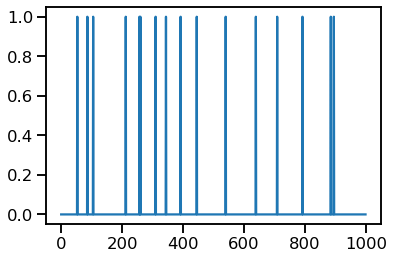

In [27]:
plt.plot(spiketrain[0:1000])

In [28]:
# Now we can compute the Fano Factor, which requires the spike train , during the task
fano_factor = np.var(spiketrain) / np.mean(spiketrain)
print('This cell has a Fano factor of {}'.format(fano_factor))

This cell has a Fano factor of 0.9879246999512845


One of the key reasons to define a spike train is so that we can smooth it to get a continuous **estimate** of spiking. We do this by convolving the spike train with a Gaussian kernel.

In [29]:
# Continuous firing rate parameters
bin_width_gauss = 10 # ms. set a wider bin width so we dont have a SUPER LONG vector! 
gauss_sr = int(1000 / bin_width_gauss)

In [30]:
times_offset = times - times[0]

# make the bins 
binnedTime = np.arange(times_offset[0], times_offset[-1] + np.diff(times_offset)[0], bin_width_gauss)

# initialize the array
spkt = np.zeros(binnedTime.shape)

# Map the spike times to bins.
map_to_bins = np.digitize(st_baselined, binnedTime)
for i in map_to_bins:
    if i > 0:
        spkt[i - 1] += 1

In [31]:
# Define a window to filter in 
filt_window = np.arange(-1000, 1000, bin_width_gauss)

# factor to convert the convovled firing rate into Hz (spikes/second)
conv_rate_gaussian_fr = 1/(bin_width_gauss/1000) 

# Mess around with the std of the gaussian kernel - see how it changes the firing rate estimate 
smoothing_width = 75 # ms 

# Define the gaussian kernel
gaussian_kernel = 1. / np.sqrt(2 * np.pi * smoothing_width ** 2) * np.exp(
    -filt_window ** 2. / (2 * smoothing_width ** 2))

# Normalize the kernel so that the area sums to 1
gaussian_kernel =  gaussian_kernel / gaussian_kernel.sum()

# Do the smoothing! 
spkt_conv = conv_rate_gaussian_fr * fftconvolve(spkt, gaussian_kernel, 'same') 

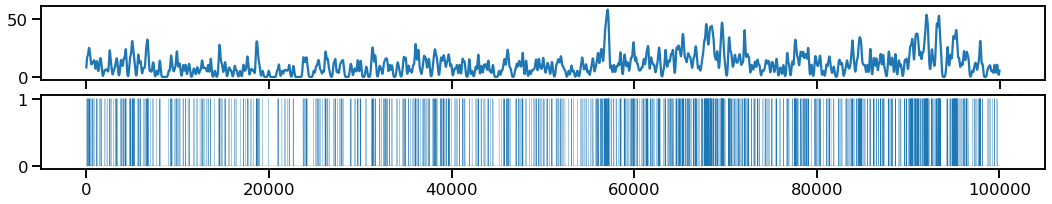

In [32]:
f, (gauss, train) = plt.subplots(2, 1, figsize=[18,3])

# Plot 100 s of data
time_win = 100
gauss.plot(spkt_conv[0:(time_win*gauss_sr)])
train.plot(spiketrain[0:(time_win*st_sr)], linewidth=0.2)

Having done all this table setting, let's look at how neural spiking changes in relation to task events. In general, the most useful tool for visualizing stimulus-related changes in the firing rate is the **peri-event rasters and histograms**. 

First, we have to do some data wrangling. The events here are not organized by trial/event, so we need to do that, then use our baselined spikes and the timesoffset field to parse the spiking the same way. 

In [35]:
## TASK ANALYSIS

In [49]:
all_response_times = nwbfile.intervals['trials'].response_time.data[:]

time_window = [-500, 500]

# grab the spikes surrounding each stimulus 
spike_times_per_event = [] 
for response in all_response_times:
    st_to_keep_event = np.where(np.logical_and(st_baselined >= response + time_window[0], 
                                               st_baselined <= response + time_window[1]))[0].astype(int)
    spike_times_per_event.append(st_baselined[st_to_keep_event] - response)

/home1/tom.donoghue/.conda/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/home1/tom.donoghue/.conda/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


/home1/tom.donoghue/.conda/envs/eeg/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


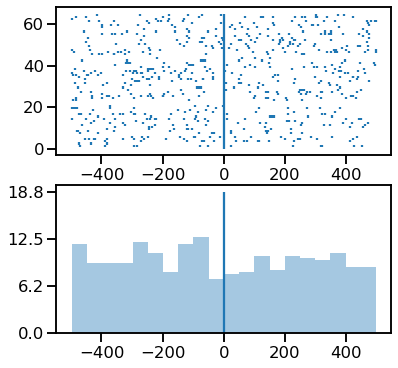

In [55]:
f, (raster, spike_hist) = plt.subplots(2, 1, figsize=[6,6])

# Plot the raster
trial = 1
for row in spike_times_per_event: 
    raster.vlines(row, trial, trial+1)
    trial += 1
raster.vlines(0, 0, trial)

# Compute the histogram in 50 ms bins
bin_width_ms = 50 
n_bins = int(1000 / bin_width_ms)
H, b = np.histogram(np.hstack(spike_times_per_event), n_bins)
rate_factor = (bin_width_ms * len(nwbfile.intervals['trials']) / 1000)

sns.distplot(np.hstack(spike_times_per_event), bins=n_bins, kde=False, ax=spike_hist)
# Scale the y-axis so we are plotting firing rate in our bins, not just counts of spikes 
y_vals = spike_hist.get_yticks()
spike_hist.set_yticklabels(['{:3.1f}'.format(x/rate_factor) for x in y_vals])
spike_hist.vlines(0, 0, y_vals.max())

How do we do statistics for a PSTH? We won't cover that in specific detail here. But pay attention when you do problem #4 in the Assignments as the permutation statistics you do there will be very similar to what you might do for as PSTH. Broadly, you can either:

1) Identify specific times of increased firing: Generate surrogate PSTHs (i.e. 500 null observations per time bin). Compute a p-value for every bin. Do multiple comparisons correction across time bins. Are any time bins significantly higher/lower than surrogates? 

2) Compute mean firing rate pre and post and do a paired t-test. 


### PLACE ENCODING

Now we want to do the spicy stuff: looking at neural activity as a function of position.

Up until this point, we have been binning spike counts by **time**. Now it's time to bin spike counts by **position**.

The easiest way to do this is to utilize pandas dataframe functionality, particularly the ```cut``` function to cut data into bins and the  ```groupby``` function to apply a function to these split data. 

In [78]:
# ...
position = nwbfile.acquisition['position']['position']
times = position.timestamps
pos = position.data

In [117]:
# Cut the environment into spatial bins, also collecting the bin edges
n_spatial_bins = 20
spatial_bins, bin_edges = pd.cut(pos[:], bins=n_spatial_bins, retbins=True,
                                 include_lowest=True, labels=np.arange(n_spatial_bins))

In [104]:
# 
data_df = pd.read_csv('data/spatial_dataframe.csv')

In [105]:
data_df

,Unnamed: 0,position,spatial_bin,object_ID,object_bin,fr,trial,subject
0,0,-33.970167,0,barrel,4,20,1,1
1,1,-33.835283,0,barrel,4,10,1,1
2,2,-33.584817,0,barrel,4,30,1,1
3,3,-33.217183,0,barrel,4,30,1,1
4,4,-32.736283,0,barrel,4,10,1,1
...,...,...,...,...,...,...,...,...
7649,7649,29.248400,18,desk,7,0,64,1
7650,7650,30.118150,18,desk,7,0,64,1
7651,7651,30.887517,18,desk,7,20,64,1
7652,7652,31.569600,19,desk,7,0,64,1


<AxesSubplot:xlabel='spatial_bin', ylabel='fr'>

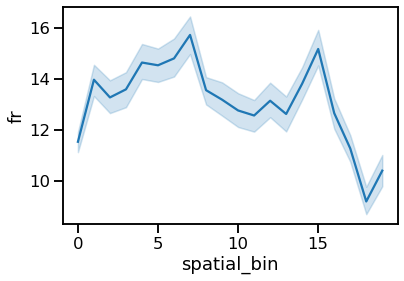

In [106]:
# Compute the actual spatially binned firing rate by averaging the firing rate over each bin 
spatially_binned_fr = data_df.groupby(by='spatial_bin').mean()
# Plot
sns.lineplot(x='spatial_bin', y='fr', data=data_df, ci=68) # Note that seaborn does the groupby().mean() itself 

<AxesSubplot:xlabel='object_ID', ylabel='fr'>

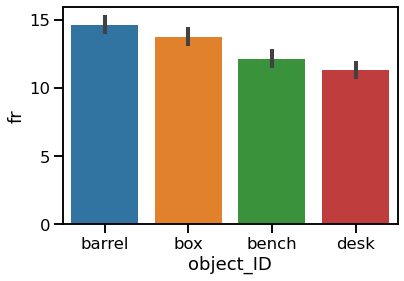

In [107]:
# Compute the firing rate for each different object cued for memory 
sns.barplot(x='object_ID', y='fr', data=data_df)

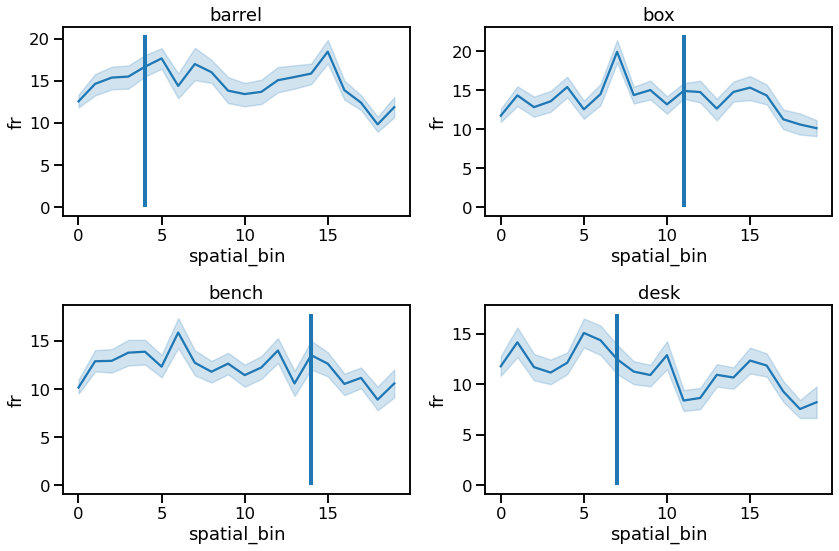

In [121]:
# Does spatial firing rate differ as a function of which object is cued for retrieval? 
diff_objects = data_df.object_ID.unique()
fig, axes = plt.subplots(2, 2, figsize=[12, 8])

for ind, obj in enumerate(axes.flatten()):
    sns.lineplot(x='spatial_bin', y='fr', data=data_df[data_df.object_ID==diff_objects[ind]], ci=68, ax=obj)
    obj.vlines(data_df[data_df.object_ID==diff_objects[ind]].object_bin, 0, obj.get_ylim()[-1])
    obj.set_title(diff_objects[ind])

fig.tight_layout()

### Statistical Analysis

Our next goal is to statistically determine if this neuron shows significant spatial tuning, significant object tuning, or an interaction of the two. Let's discuss each of these possibilites:

1) Significant spatial tuning: A neuron significantly increases it's firing in a particular location. We would call this a place cell. 

2) Significant object tuning: A neuron significantly increases it's firing when a particular object is cued for memory retrieval. 

3) Significant spatial x object: A neuron significantly increases it's firing in a particular location **as a function of the object cued for memory**. Put another way, the memory a person is cued to retrieve is affecting the spatial tuning of the neuron.

To assess these possibilities in an individual neuron, we are going to do a simple 2-way ANOVA. 

In [110]:
# Define the formula of interest that we want to test
formula = 'fr~C(spatial_bin) + C(object_ID) + C(spatial_bin)*C(object_ID)'

In [122]:
# Fit the model
model = ols(formula, data_df).fit()
aov_table = anova_lm(model, typ=2)

# Grab variables of interest
F_int = aov_table['F']['C(spatial_bin):C(object_ID)']
F_pos = aov_table['F']['C(spatial_bin)']
F_obj = aov_table['F']['C(object_ID)']

In [124]:
# Check the model fit results
aov_table 

,sum_sq,df,F,PR(>F)
C(spatial_bin),1.877170e+04,19.0,6.779549,3.681931e-18
C(object_ID),1.320507e+04,3.0,30.204404,2.104132e-19
C(spatial_bin):C(object_ID),1.036921e+04,57.0,1.248308,9.945531e-02
Residual,1.103760e+06,7574.0,NaN,NaN


Note that in the above, this neuron appears to have significant encoding of some features of interest!

However, we must keep in mind that our data might violate normality assumptions for computing the significance of the test-statistic (F)!

In order to more robustly evaluate the statistics, we should compute our own null distributions from surrogate data to assess significance.

## Assignment:

In this assignment, you will analyze human single neuron activity during a virtual-reality spatial memory task. In this task, subjects move down a linear track while encoding and retrieving the locations of objects along the track. You will plot neuronal spiking as a function of time and spatial position, and apply statistical methods for assessing significant changes in both domains. You will also measure the influence of memory cues and memory performance on spiking activity. 

1) Write a general function to plot the raster and histogram at a user defined time window and bin length (for the histogram). Use it to plot the rasters and histograms for CueOn, CueOff, FeedbackOn and FeedbackOff. This function should use baselined spike times and baselined event times/trial as input. Plot the output for one neuron. 

2) Write a similar function using the smoothed spiking activity instead of the PSTH. Keep in mind that the we computed the smoothed spiking activity at 100 Hz. Be sure to allow users to input width of smoothing kernel. You may want to write a separate function to smooth the firing rate, and call that within your function to plot the raster + smoothed firing rate. Plot the output for one neuron, with 3 different smoothing widths for your kernel. 

3) Calculate the mean firing rate and the error on every trial, and plot firing rate as a function of error. Hint: this is going to require that you again split the events into trials using the ```trialNum``` field. 
BONUS: Is there a statistical relationship between firing rate and memory performance? 

4) Do some shuffling to determine if the F-statistic from the spatial ANOVA is significant. Hint: use np.roll() to circularly shift data in a pandas dataframe: 
```df.reindex(index=np.roll(df.index, shift))```. If you see any neurons with a significant interaction in the ANOVA, make a plot of the spatial firing rate split by object. If you see any neurons that do not have a significant interaction but do have a significant main effect of location, make a plot of the spatial firing rate over all trials. 
